In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))

from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA

import romnet                            as rmnt

FigDir = os.path.join(WORKSPACE_PATH, '../Desktop/PPCA_Figures/')

ColorVec         = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec          = ['-',':','--','.-']*10

Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


In [2]:
# d  = 10
# q  = 2


# Z   = np.random.normal(0,1,(3000,q))
# Zdf = pd.DataFrame(Z, columns=['$z_1$','$z_2$'])

# WW = (np.random.rand(d,2)-0.5)*2.

# X  = Z @ WW.T

In [3]:
# Zdf = pd.DataFrame(Z, columns=['$z_1$','$z_2$'])
# sns.displot(Zdf)

In [4]:
# d  = 10
# q  = 2


# Z  = np.random.normal(0,1,(3000,q))

# WW = (np.random.rand(d,2)-0.5)*2.

# X  = Z @ WW.T

(1e-07, 1.0)

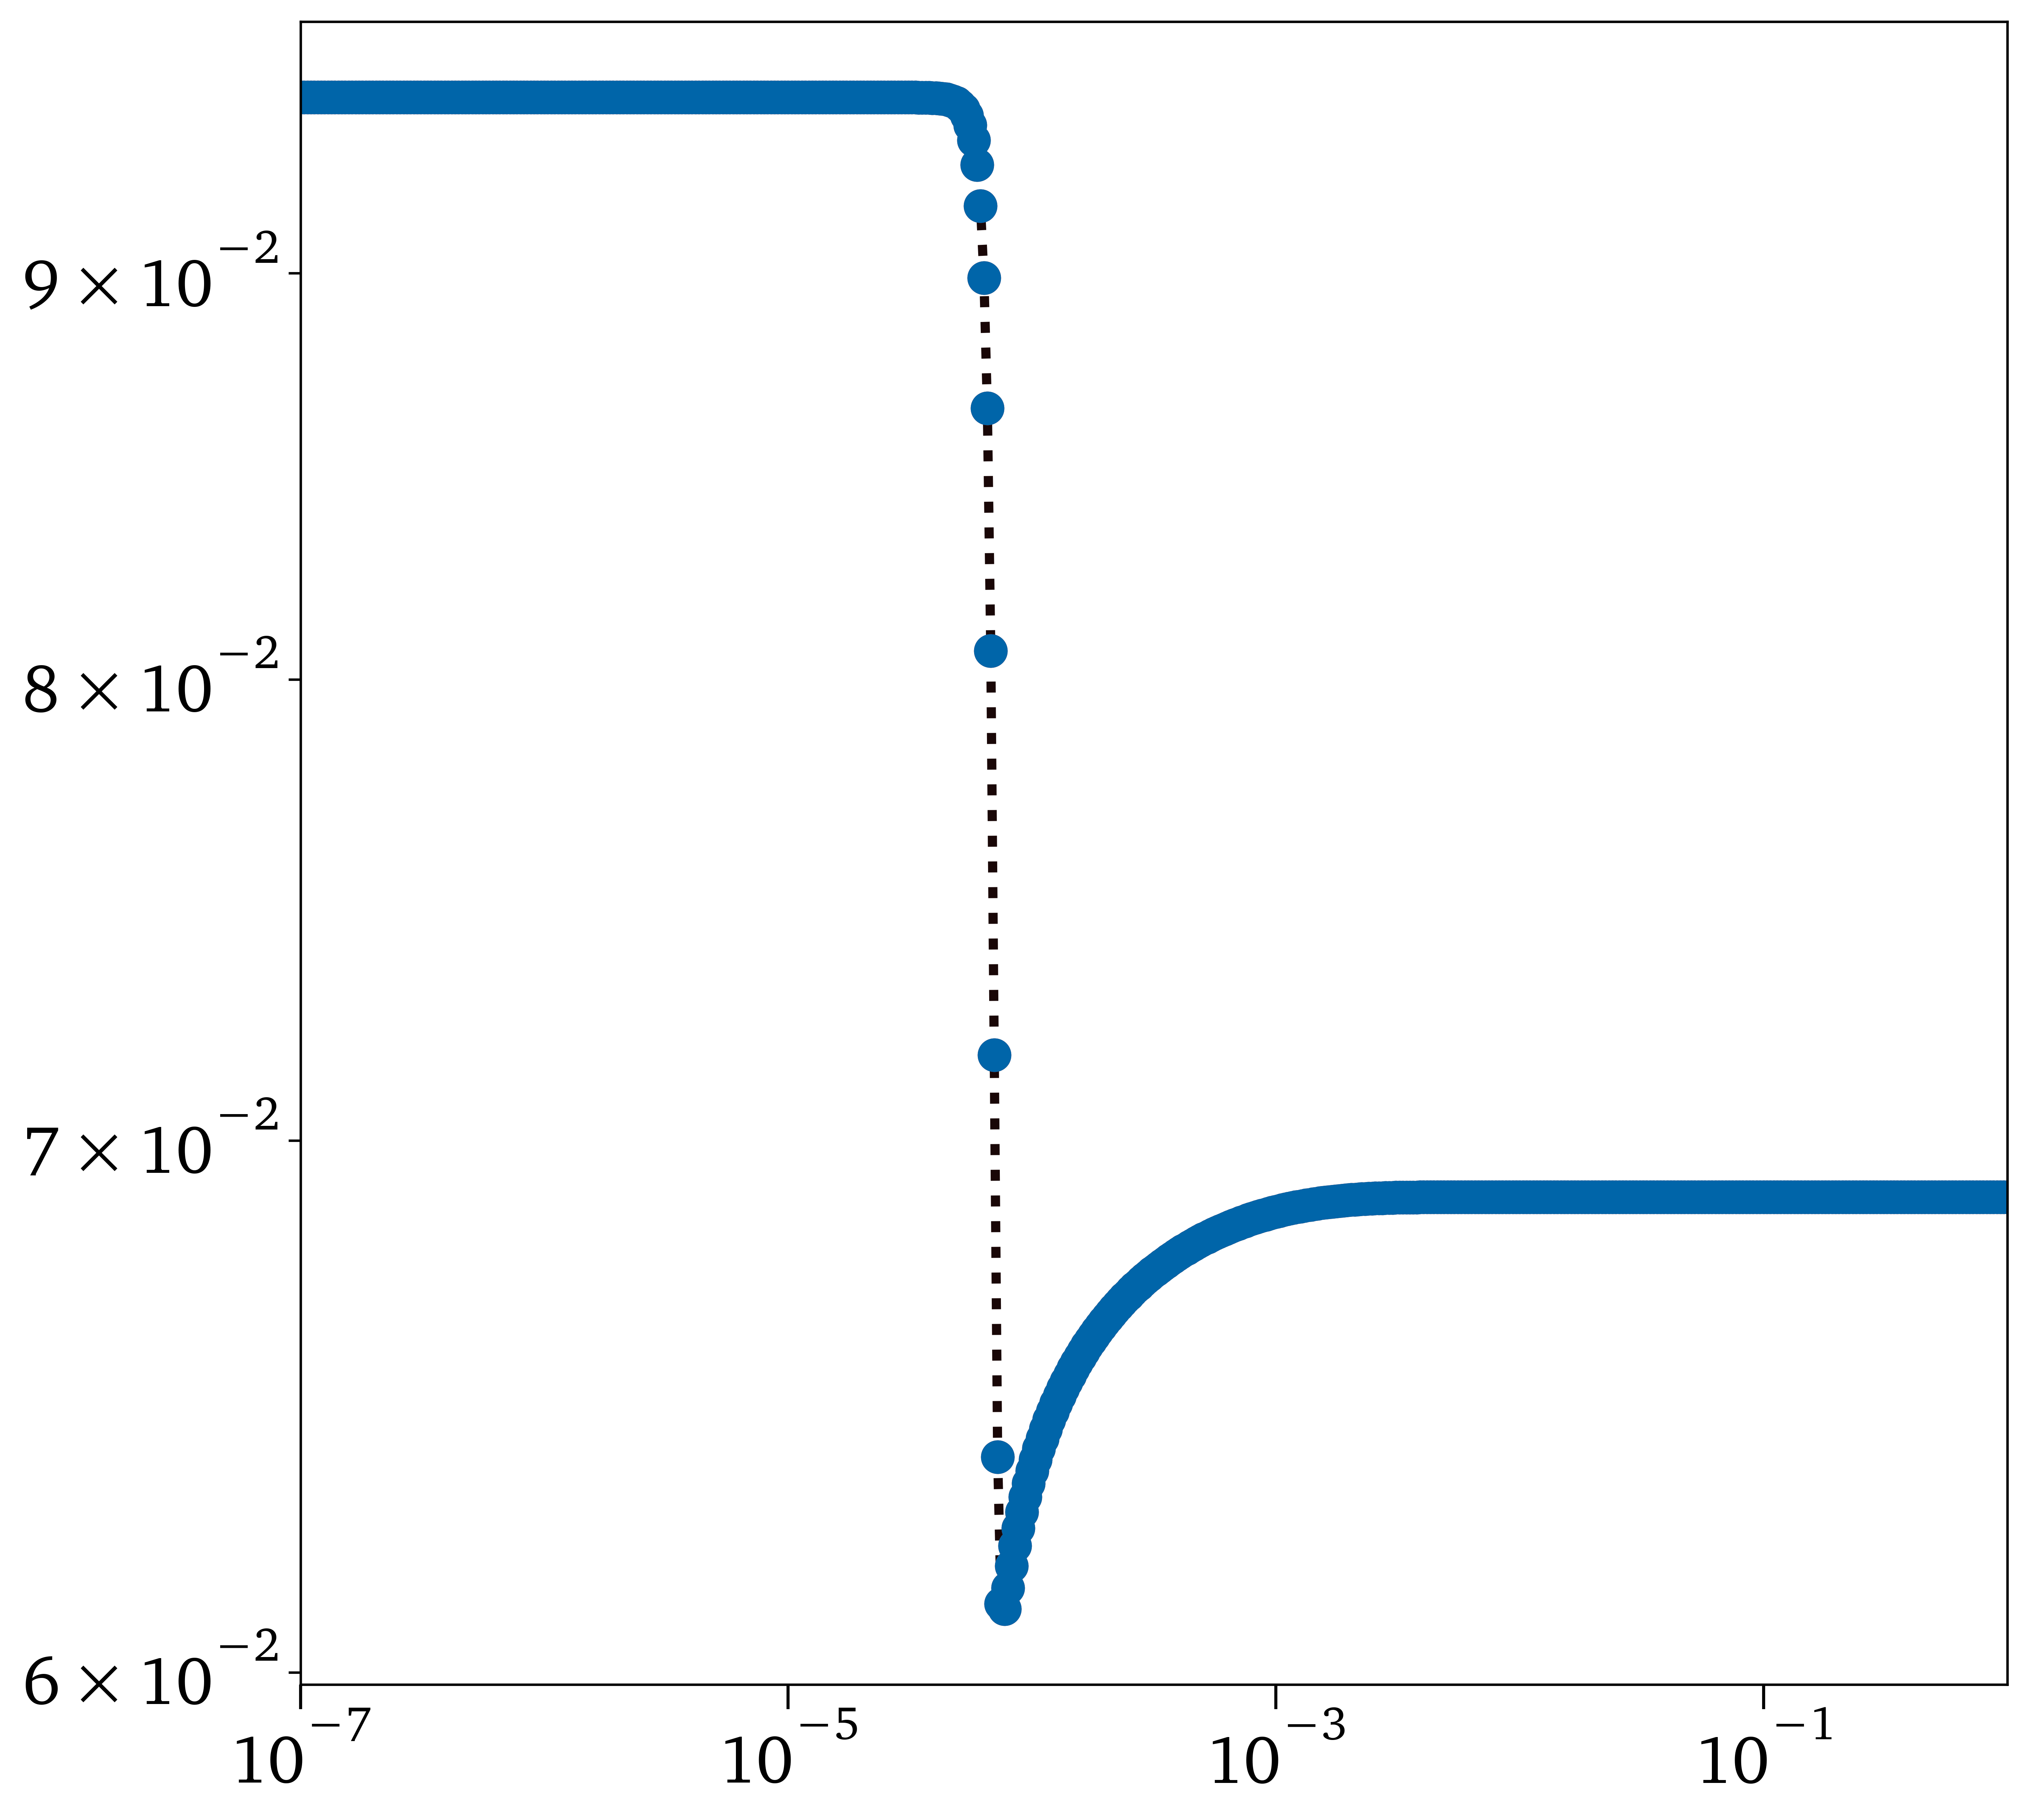

In [5]:
Vars     = ['T','H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2']# list(Data.columns)[1::]

scale    = 'log10'

NoiseStd = 1.e-10 #5.e-2
q        = 10
iPlot    = 1

XOrig    = []

FileName = '/Users/sventur/WORKSPACE/ROMNet/Data/0DReact_Isobaric_500Cases_H2_NoNoise/Orig/train/ext/y.csv.1'
Data     = pd.read_csv(FileName)
tVec     = Data.t
XOrig    = Data[Vars].to_numpy()

plt.plot(tVec, XOrig[:,iPlot], ':')

d        = XOrig.shape[1]

if (scale == 'lin'):
    XOrig_   = XOrig
elif (scale == 'log10'):
    XOrig    = np.maximum(XOrig, 1.e-30)
    XOrig_   = np.log10(XOrig) 


XMean    = XOrig_.mean(axis=0)
XStd     = XOrig_.std(axis=0)

X        = (XOrig_ - XMean) / XStd


X        = X * np.random.normal(1., NoiseStd, (X.shape[0],X.shape[1]))
XPlot    = X * XStd +  XMean

if (scale == 'log10'):
    XPlot = 10**XPlot
    
plt.plot(tVec, XPlot[:,iPlot], 'o')
plt.plot(tVec, XPlot[:,iPlot], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.e-7, 1.e0])

In [6]:
Vars     = ['T','H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2']# list(Data.columns)[1::]
n_cases  = 500

XOrig    = []
for iCase in range(n_cases):
    try:
        FileName = '/Users/sventur/WORKSPACE/ROMNet/Data/0DReact_Isobaric_500Cases_H2_NoNoise/Orig/train/ext/y.csv.'+str(iCase+1)
        Data     = pd.read_csv(FileName)
        XOrig.append(Data[Vars])
    except:
        pass
XOrig    = pd.concat(XOrig).to_numpy()

d        = XOrig.shape[1]

if (scale == 'lin'):
    XOrig_   = XOrig
elif (scale == 'log10'):
    XOrig    = np.maximum(XOrig, 1.e-30)
    XOrig_   = np.log10(XOrig) 

XOrig_   = XOrig_ * np.random.normal(1., NoiseStd, (XOrig_.shape[0],XOrig_.shape[1]))

XMean    = XOrig_.mean(axis=0)
XStd     = XOrig_.std(axis=0)

X        = (XOrig_ - XMean) / XStd
tVec     = Data.t

Text(0, 0.5, '$x_2$')

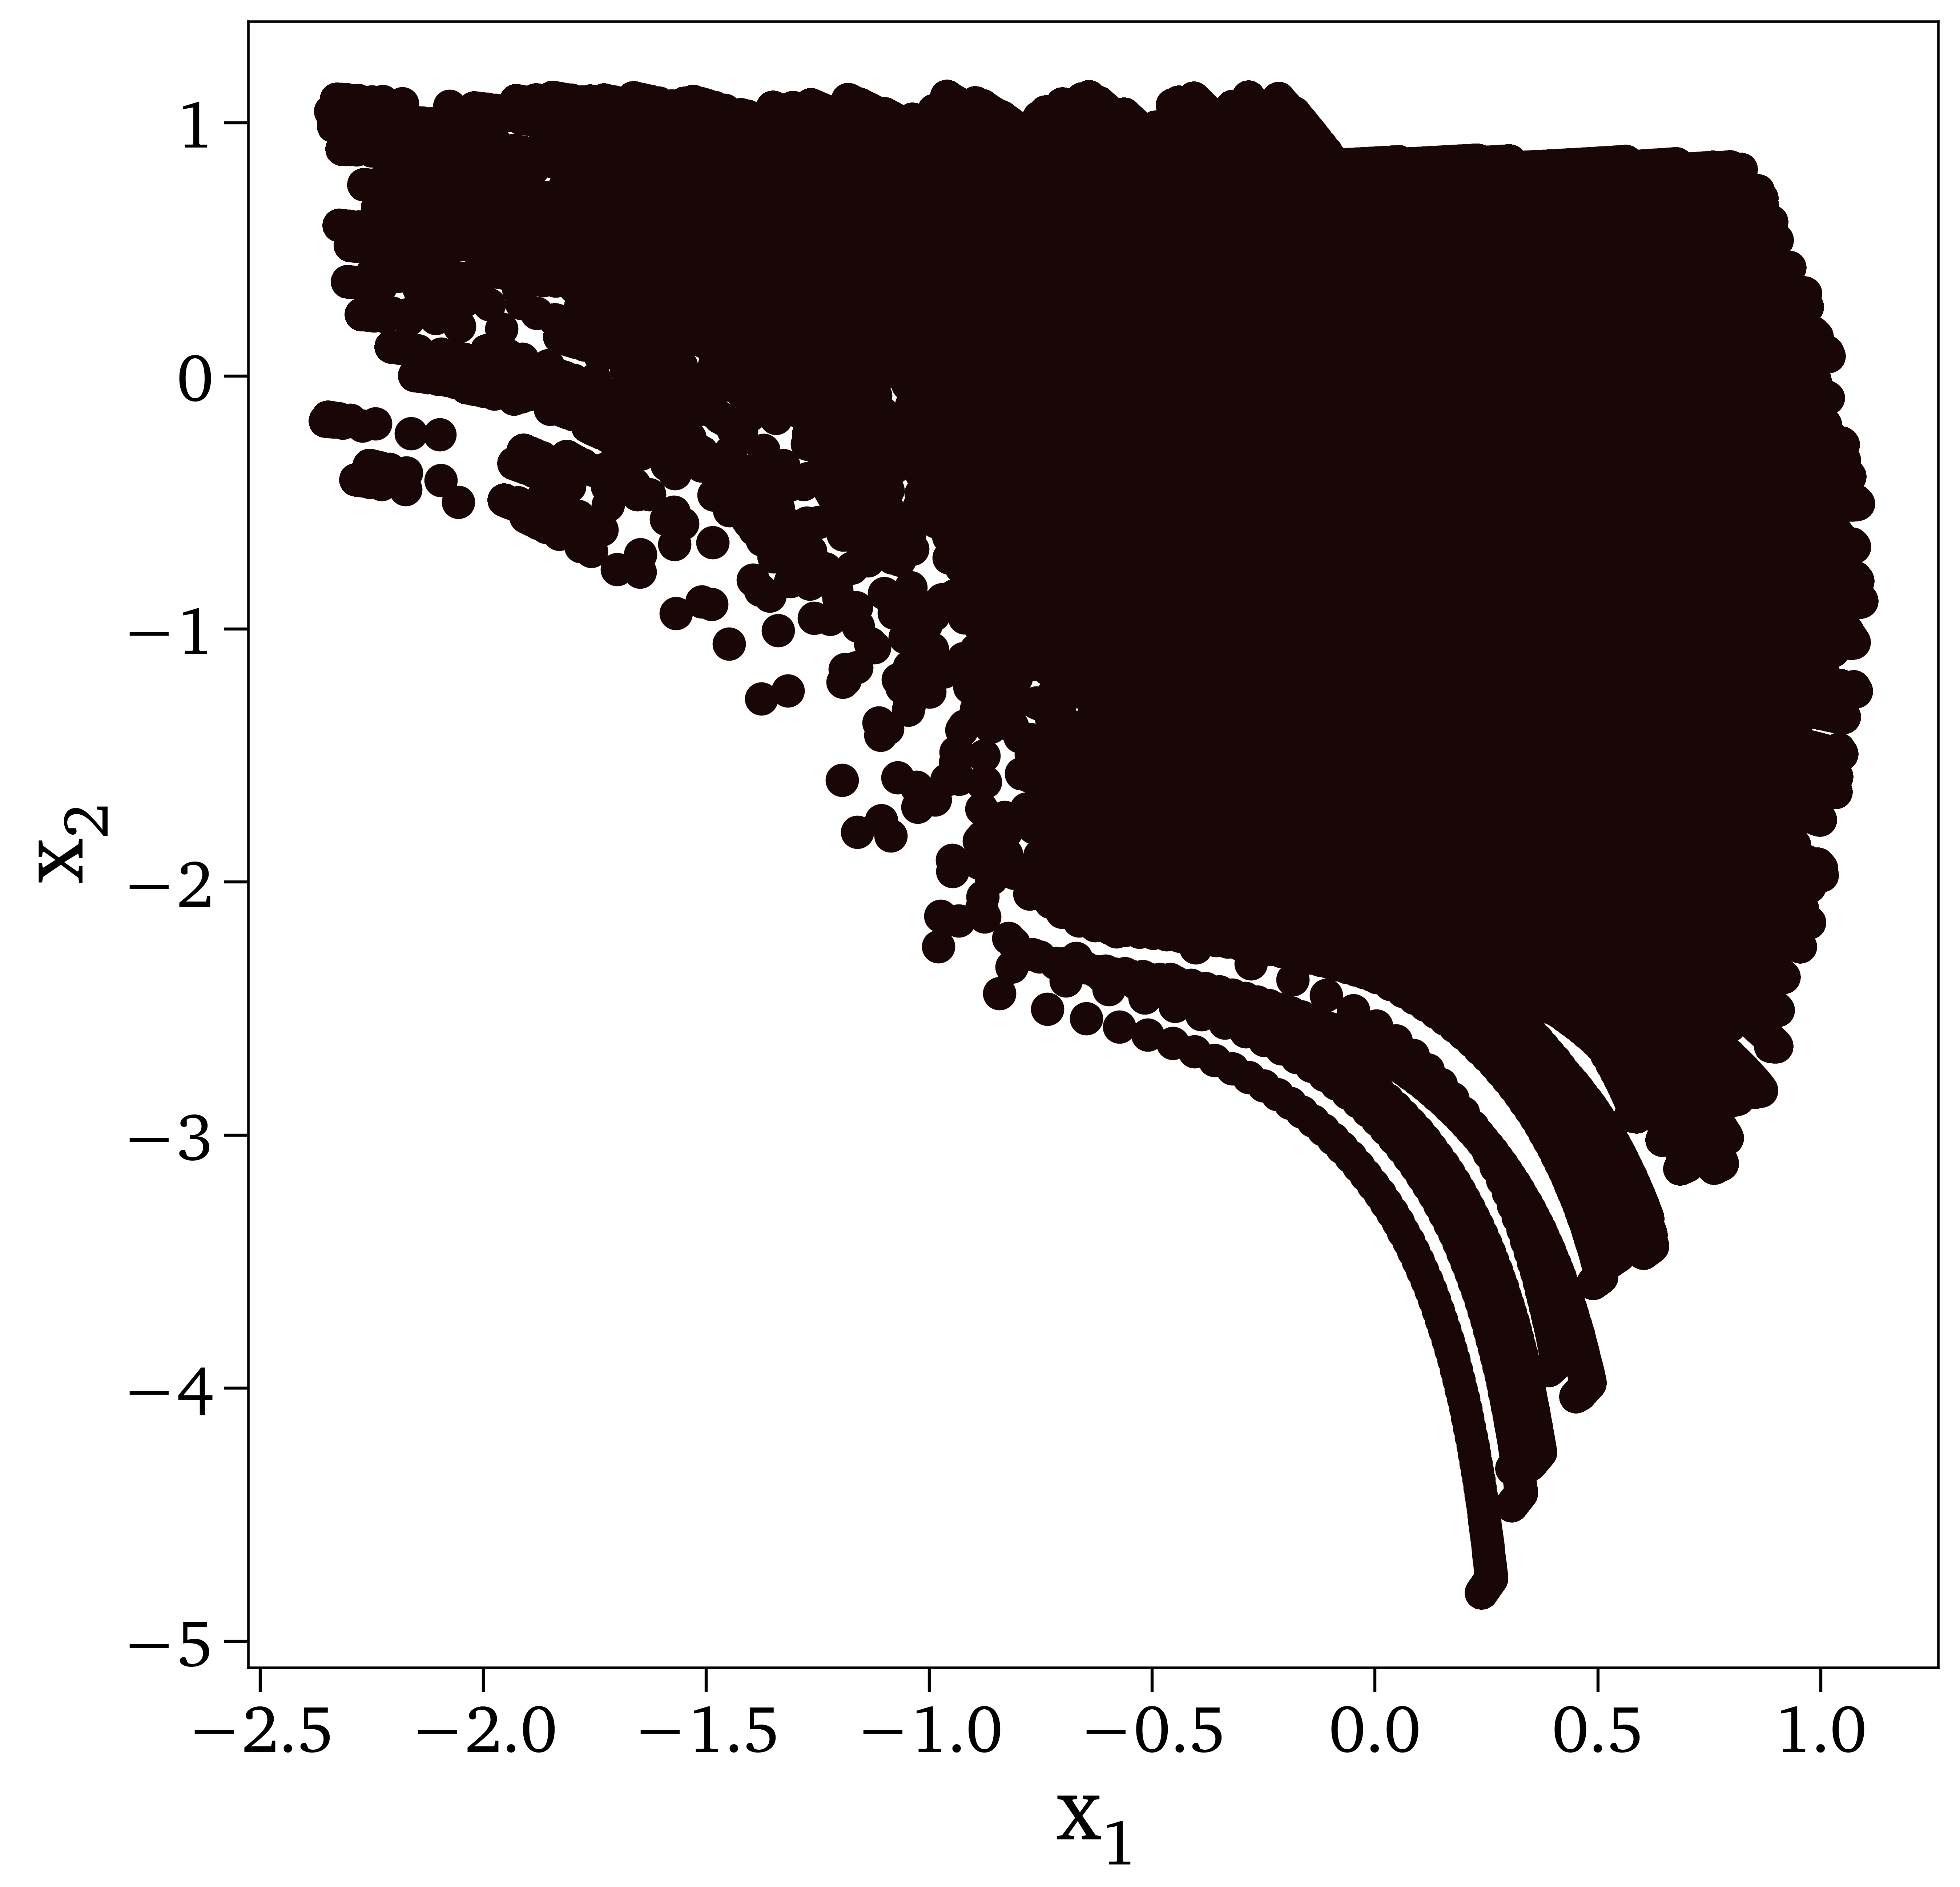

In [7]:
i1 = 0
i2 = 1

plt.plot(X[:,i1], X[:,i2], 'o')
plt.xlabel('$x_'+str(i1+1)+'$')
plt.ylabel('$x_'+str(i2+1)+'$')

In [8]:
Mu_ml = np.mean(X,axis=0)
#print("Data mean:")
#print(Mu_ml)

X_cov = np.cov(X,rowvar=False)
#print("Data cov:")
#print(X_cov)

In [9]:
# No hidden variables < no visibles = d

# Variance
lambdas, eigenvecs = np.linalg.eig(X_cov)
# idx       = lambdas.argsort()[::-1]   
# lambdas   = lambdas[idx]
# eigenvecs = - eigenvecs[:,idx]

Var_ml = (1.0 / (d-q+1.e-10)) * sum([lambdas[j] for j in range(q,d)])
#print("Var ML:")
#print(Var_ml)

# Weight matrix
uq = eigenvecs[:,:q]
#print("uq:")
#print(uq)

lambdaq = np.diag(lambdas[:q])
#print("lambdaq")
#print(lambdaq)

W_ml = ( uq @ np.sqrt(lambdaq - Var_ml * np.eye(q)) ).real
#print("Weight matrix ML:")
#print(W_ml)

In [10]:
M   = (np.transpose(W_ml) @ W_ml + Var_ml * np.eye(q)).real
Cov = Var_ml * np.linalg.inv(M)

print(Var_ml)

0.0008617315247313207


In [11]:
def sample_hidden_given_visible(W_ml, Mu_ml, Var_ml, X):

    q = W_ml.shape[1]
    M = (np.transpose(W_ml) @ W_ml + Var_ml * np.eye(q)).real
    
    Cov        = Var_ml * np.linalg.inv(M)
    X_pca      = []
    X_pca_mean = []
    for x in X:
        Mean       = np.linalg.inv(M) @ np.transpose(W_ml) @ (x - Mu_ml)
        sample     = np.random.multivariate_normal(Mean, Cov, size=300)
        X_pca_mean.append(Mean)
        X_pca.append(sample.T)
    
    return np.array(X_pca_mean), Cov, np.array(X_pca)

In [12]:
# X_pca_mean, X_pca_cov, X_pca = sample_hidden_given_visible(W_ml   = W_ml,
#                                                            Mu_ml  = Mu_ml,
#                                                            Var_ml = Var_ml,
#                                                            X      = X)

In [13]:
# i1 = 1
# i2 = 1

# #plt.plot(act_hidden[:,i1], act_hidden[:,i2], 'ro')
# #plt.xlabel('$\eta_'+str(i1+1)+'$')
# #plt.ylabel('$\eta_'+str(i2+1)+'$')

# yMean = X_pca_mean[:,i1]
# yStd  = X_pca_cov[i1,i1]  

# plt.fill_between(tVec, (yMean-3*yStd), (yMean+3*yStd), color='b', alpha=0.1)
# plt.fill_between(tVec, (yMean-2*yStd), (yMean+2*yStd), color='b', alpha=.2)
# plt.fill_between(tVec, (yMean-1*yStd), (yMean+1*yStd), color='b', alpha=.3)
# plt.xscale('log')

In [14]:
# mean_hidden    = np.full(q,0)
# cov_hidden     = np.eye(q)

# no_samples     = X.shape[0]
# samples_hidden = np.random.multivariate_normal(mean_hidden, cov_hidden, size=no_samples)

In [15]:
# plt.plot(act_hidden[:,0], act_hidden[:,1],'o')
# #plt.plot(Z[:,0], Z[:,1],'o')

# Zdf_ = pd.DataFrame(samples_hidden, columns=['$z_1^R$','$z_2^R$'])
# sns.displot(Zdf_)

In [16]:
def sample_visible_given_hidden(W_ml, Mu_ml, Var_ml, X_pca):
    
    n_data    = X_pca.shape[0]
    q         = X_pca.shape[1]
    n_samples = X_pca.shape[2]
    m_samples = 1
    d         = W_ml.shape[0]

    Cov       = Var_ml * np.eye(d)

    X_        = np.zeros((n_data, d, n_samples*m_samples))
    for i_data in range(n_data):
        for i_sample in range(n_samples):
            Mean                                     = W_ml @ X_pca[i_data,:,i_sample] + Mu_ml
            X_[i_data,:,i_sample:i_sample+m_samples] = np.random.multivariate_normal(Mean, Cov, size=m_samples).T
    
    return X_

In [17]:
# X_ = sample_visible_given_hidden(W_ml   = W_ml,
#                                  Mu_ml  = Mu_ml,
#                                  Var_ml = Var_ml,
#                                  X_pca  = X_pca)

# print("Covariance visibles (data):")
# print(X_cov)
# print("Covariance visibles (sampled):")
# print(np.cov(X_, rowvar=False))

# print("Mean visibles (data):")
# print(np.mean(X, axis=0))
# print("Mean visibles (sampled):")
# print(np.mean(X_, axis=0))

In [18]:
# i1 = 0
# #i2 = 2

# # plt.plot(X[:,i1], X[:,i2], 'ko')
# # plt.plot(X_[:,i1], X_[:,i2], 'ro')
# # plt.xlabel('$x_'+str(i1+1)+'$')
# # plt.ylabel('$x_'+str(i2+1)+'$')


# yMean = np.mean(X_[:,i1,:], axis=1)
# yStd  = np.std(X_[:,i1,:], axis=1)

# plt.plot(tVec, 10.**(X[:,i1]*XStd[i1]+XMean[i1]), 'r', linewidth=1)
# plt.fill_between(tVec, 10.**((yMean-3*yStd)*XStd[i1]+XMean[i1]), 10.**((yMean+3*yStd)*XStd[i1]+XMean[i1]), color='b', alpha=.2)
# plt.fill_between(tVec, 10.**((yMean-2*yStd)*XStd[i1]+XMean[i1]), 10.**((yMean+2*yStd)*XStd[i1]+XMean[i1]), color='b', alpha=.4)
# plt.fill_between(tVec, 10.**((yMean-1*yStd)*XStd[i1]+XMean[i1]), 10.**((yMean+1*yStd)*XStd[i1]+XMean[i1]), color='b', alpha=.6)
# plt.xscale('log')
# #plt.xlim([1.e-7,1.e-2])

In [19]:
Vars       = ['T','H2','H','O','O2','OH','H2O','HO2','H2O2','N','NH','NH2','NH3','NNH','NO','NO2','N2O','HNO','N2']# list(Data.columns)[1::]
i_casesVec = [0,2,4,6,8]

i1         = 1

X          = []
tVec       = []
yMean      = []
yStd       = []
jCase      = 0
for iCase in i_casesVec:
    FileName = '/Users/sventur/WORKSPACE/ROMNet/Data/0DReact_Isobaric_500Cases_H2_NoNoise/Orig/test/ext/y.csv.'+str(iCase+1)
    Data     = pd.read_csv(FileName)
    XOrig    = Data[Vars].to_numpy()

    if (scale == 'lin'):
        XOrig_ = XOrig
    elif (scale == 'log10'):
        XOrig_ = np.log10(np.maximum(XOrig, 1.e-30))
    
    X.append((XOrig_ - XMean) / XStd)
    tVec.append(Data.t)

    X_pca_mean, X_pca_cov, X_pca = sample_hidden_given_visible(W_ml   = W_ml,
                                                               Mu_ml  = Mu_ml,
                                                               Var_ml = Var_ml,
                                                               X      = X[jCase])

    X_ = sample_visible_given_hidden(W_ml   = W_ml,
                                     Mu_ml  = Mu_ml,
                                     Var_ml = Var_ml,
                                     X_pca  = X_pca)


    yMean.append(np.mean(X_[:,i1,:], axis=1))
    yStd.append(np.std(X_[:,i1,:], axis=1))

    jCase += 1


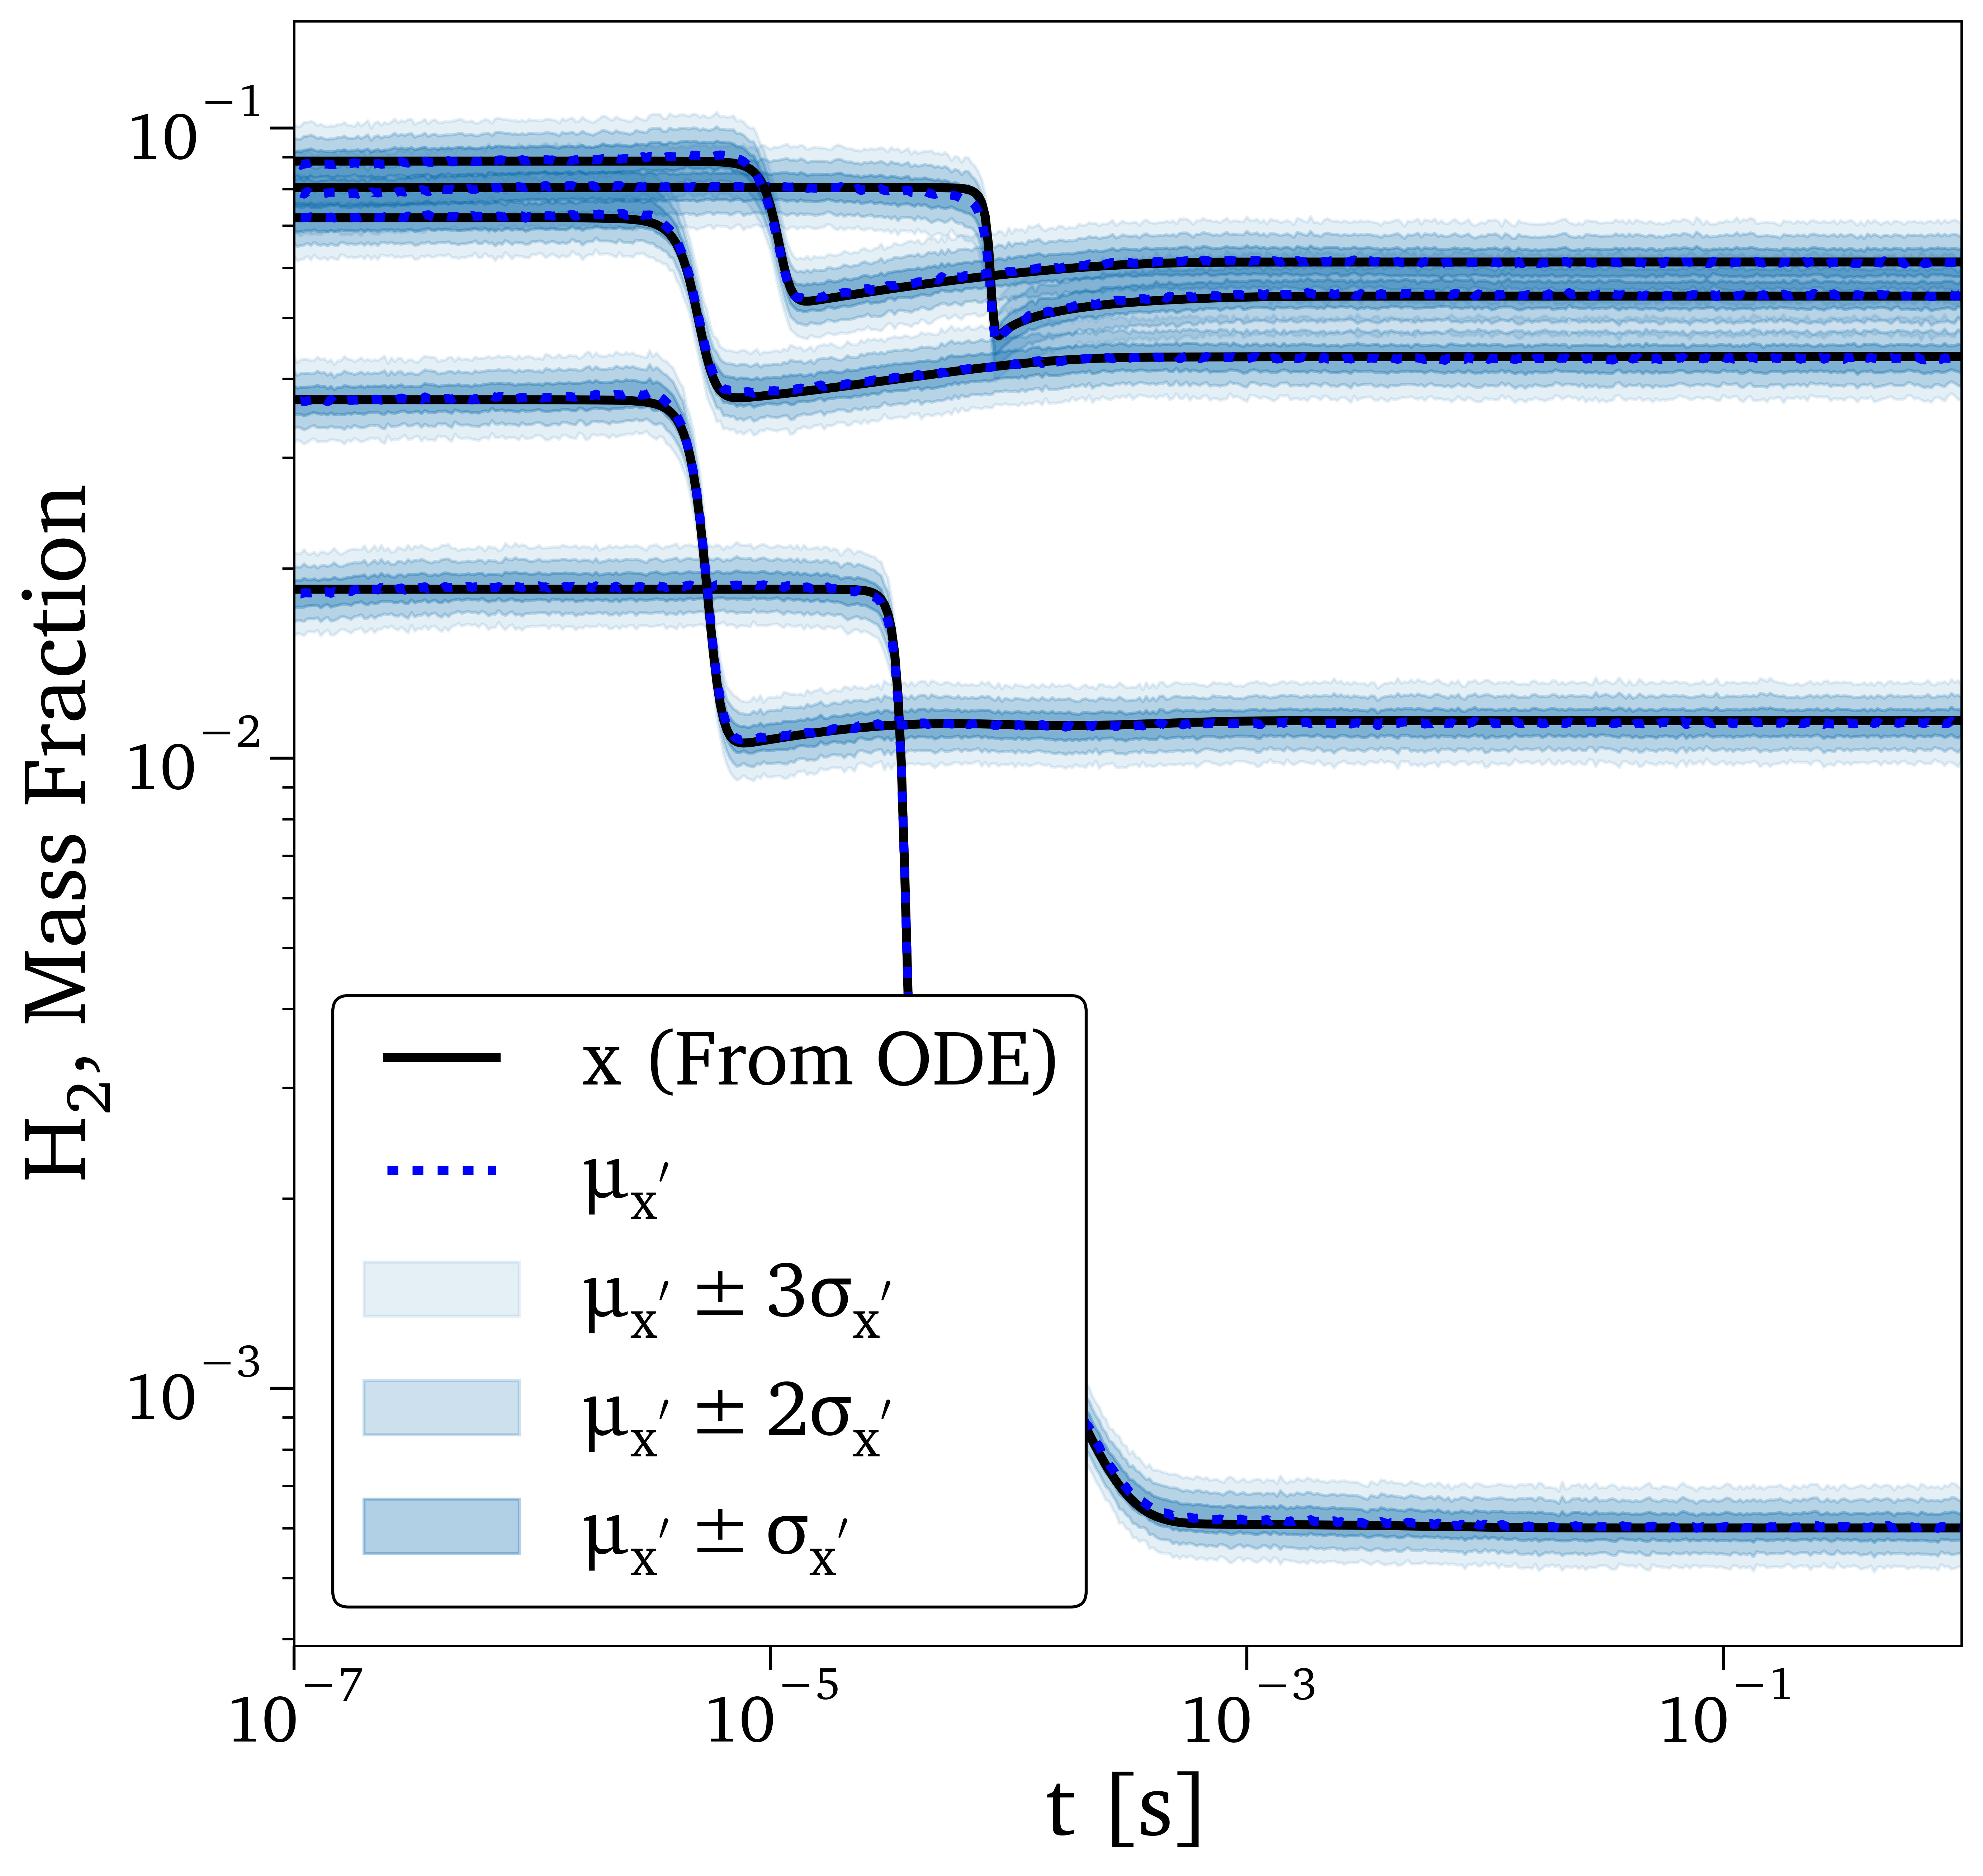

In [20]:
jCase      = 0
for iCase in i_casesVec:
    
    if (jCase == 0):
        label1 = '$x$ (From ODE)'
        label2 = "$\mu_{x'}$"
        label3 = r"$\mu_{x'} \pm 3\sigma_{x'}$"
        label4 = r"$\mu_{x'} \pm 2\sigma_{x'}$"
        label5 = r"$\mu_{x'} \pm \sigma_{x'}$"
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None
        label5 = None
    
    if (scale == 'lin'):
        plt.plot(tVec[jCase], (X[jCase][:,i1]*XStd[i1]+XMean[i1]), 'k', linewidth=3)
        plt.plot(tVec[jCase], (yMean[jCase]*XStd[i1]+XMean[i1]),   ':b', linewidth=2)
        plt.fill_between(tVec[jCase], ((yMean[jCase]-3*yStd[jCase])*XStd[i1]+XMean[i1]), ((yMean[jCase]+3*yStd[jCase])*XStd[i1]+XMean[i1]), color=ColorVec[2], alpha=.1)
        plt.fill_between(tVec[jCase], ((yMean[jCase]-2*yStd[jCase])*XStd[i1]+XMean[i1]), ((yMean[jCase]+2*yStd[jCase])*XStd[i1]+XMean[i1]), color=ColorVec[2], alpha=.2)
        plt.fill_between(tVec[jCase], ((yMean[jCase]-1*yStd[jCase])*XStd[i1]+XMean[i1]), ((yMean[jCase]+1*yStd[jCase])*XStd[i1]+XMean[i1]), color=ColorVec[2], alpha=.3)
    
    elif (scale == 'log10'):
        plt.plot(tVec[jCase], 10.**(X[jCase][:,i1]*XStd[i1]+XMean[i1]), 'k',  linewidth=3, label=label1)
        plt.plot(tVec[jCase], 10.**(yMean[jCase]*XStd[i1]+XMean[i1]),   ':b', linewidth=3, label=label2)
        plt.fill_between(tVec[jCase], 10.**((yMean[jCase]-3*yStd[jCase])*XStd[i1]+XMean[i1]), 10.**((yMean[jCase]+3*yStd[jCase])*XStd[i1]+XMean[i1]), color=ColorVec[2], alpha=.1, label=label3)
        plt.fill_between(tVec[jCase], 10.**((yMean[jCase]-2*yStd[jCase])*XStd[i1]+XMean[i1]), 10.**((yMean[jCase]+2*yStd[jCase])*XStd[i1]+XMean[i1]), color=ColorVec[2], alpha=.2, label=label4)
        plt.fill_between(tVec[jCase], 10.**((yMean[jCase]-1*yStd[jCase])*XStd[i1]+XMean[i1]), 10.**((yMean[jCase]+1*yStd[jCase])*XStd[i1]+XMean[i1]), color=ColorVec[2], alpha=.3, label=label5)
    
    jCase += 1
    
plt.xscale('log')
if (scale == 'log10'):
    plt.yscale('log')
plt.xlim([1.e-7,1.e0])
#plt.xlim([1.e-7,1.e-2])
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('H${}_2$, Mass Fraction')

if (FigDir):
    plt.savefig(FigDir+'/PPCA_Test_H2.png', format='png', bbox_inches='tight')